In [5]:
library("CCA")
library("dplyr")
library("ggplot2")
library("gstat")
library("sp")
library("spacetime")
library("STRbook")
library("tidyr")

Loading required package: fda

Loading required package: splines



Loading required package: fds

Loading required package: rainbow

Loading required package: MASS

Loading required package: pcaPP

Loading required package: RCurl

Loading required package: deSolve


Attaching package: 'fda'


The following object is masked from 'package:graphics':

    matplot


Loading required package: fields

Loading required package: spam

Spam version 2.11-0 (2024-10-03) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


Attaching package: 'spam'


The following objects are masked from 'package:base':

    backsolve, forwardsolve


Loading required package: viridisLite


Try help(fields) to get started.


Attaching package: 'dplyr'


The following object is masked from 'package:MASS':

    select


The following objects are masked from 'package:stats':

    filter, lag


The following obje

In [6]:
set.seed(1)

In [7]:
data("NOAA_df_1990", package = "STRbook")
Tmax <- filter(NOAA_df_1990,
# subset the data
proc == "Tmax" &
# only max temperature
month %in% 5:9 &
# May to September
year == 1993)
# year of 1993
Tmax$t <- Tmax$julian - 728049

In [8]:
spat_av <- group_by(Tmax, lat, lon) %>%
# group by lon-lat
summarise(mu_emp = mean(z))

`summarise()` has grouped output by 'lat'. You can override using the `.groups`
argument.


In [9]:
lat_means <- ggplot(spat_av) +
geom_point(aes(lat, mu_emp)) +
xlab("Latitude (deg)") +
ylab("Maximum temperature (degF)") + theme_bw()
lon_means <- ggplot(spat_av) +
geom_point(aes(lon, mu_emp)) +
xlab("Longitude (deg)") +
ylab("Maximum temperature (degF)") + theme_bw()

In [10]:
Tmax_av <- group_by(Tmax, date) %>%
summarise(meanTmax = mean(z))

In [11]:
gTmaxav <-
ggplot() +
geom_line(data = Tmax,aes(x = date, y = z, group = id),
colour = "blue", alpha = 0.04) +
geom_line(data = Tmax_av, aes(x = date, y = meanTmax)) +
xlab("Month") + ylab("Maximum temperature (degF)") +
theme_bw()

In [12]:
lm1 <- lm(z ~ lat + t + I(t^2), data = Tmax) # fit a linear model
Tmax$residuals <- residuals(lm1)

In [16]:
library(dplyr)

spat_df <- Tmax %>%
  filter(t == 1) %>%          # lon/lat coords of stations
  select(lon, lat) %>%       # select lon/lat only
  arrange(lon, lat)          # sort ascending by lon/lat

m <- nrow(spat_df)           # Correct variable name here


In [17]:
X <- select(Tmax, lon, lat, residuals, t) %>% # select columns
spread(t, residuals) %>%
# make time-wide
select(-lon, -lat) %>%
# drop coord info
t()

In [18]:
Lag0_cov <- cov(X, use = 'complete.obs')
Lag1_cov <- cov(X[-1, ], X[-nrow(X),], use = 'complete.obs')

In [19]:
spat_df$n <- 1:nrow(spat_df)
# assign an index to each station
lim_lon <- range(spat_df$lon)
# range of lon coordinates
lon_strips <- seq(lim_lon[1],
# create 4 long. strip boundaries
lim_lon[2],
length = 5)
spat_df$lon_strip <- cut(spat_df$lon,
# bin the lon into
lon_strips,
# their respective bins
labels = FALSE,
# don't assign labels
include.lowest = TRUE) # include edges

In [20]:
head(spat_df)

,lon,lat,n,lon_strip
,<dbl>,<dbl>,<int>,<int>
1,-99.96667,37.76667,1,1
2,-99.76667,36.30000,2,1
3,-99.68333,32.43333,3,1
4,-99.05000,35.00000,4,1
5,-98.81667,38.86666,5,1
6,-98.51667,33.98333,6,1


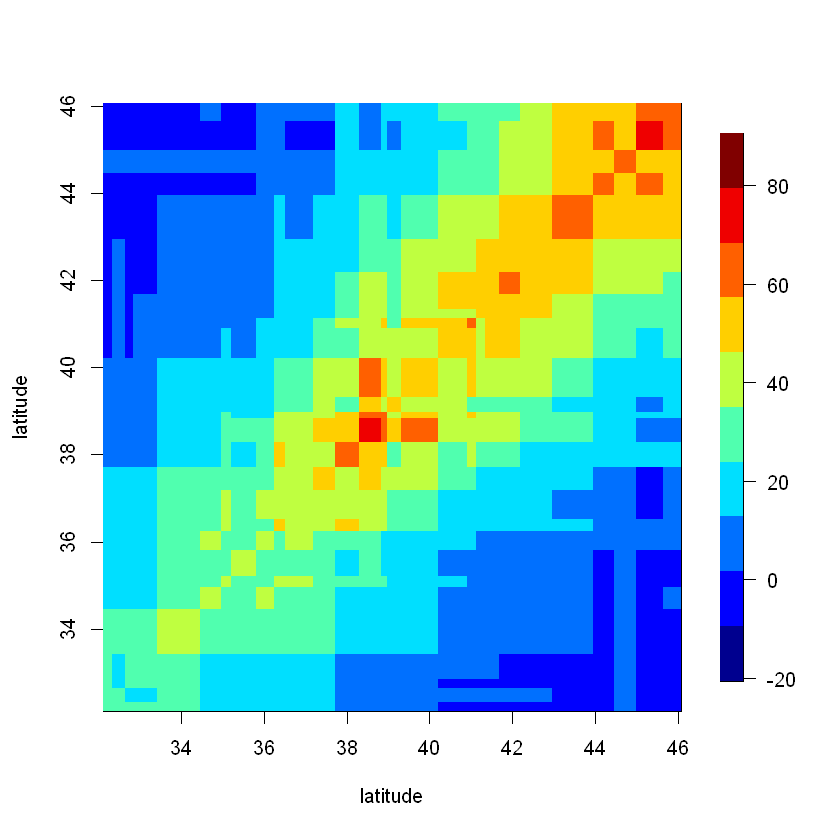

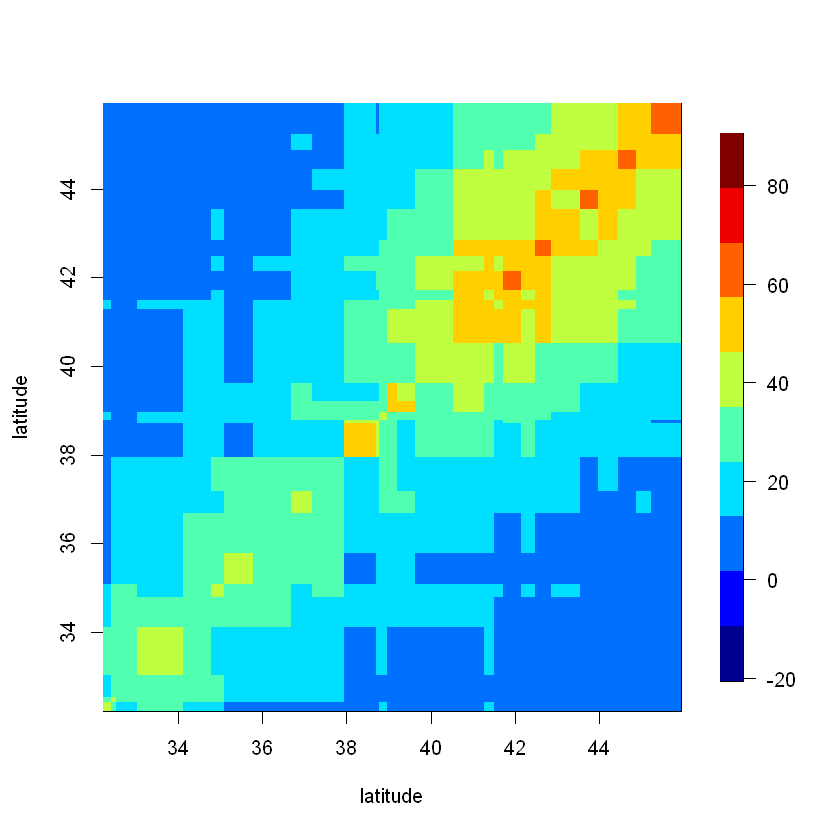

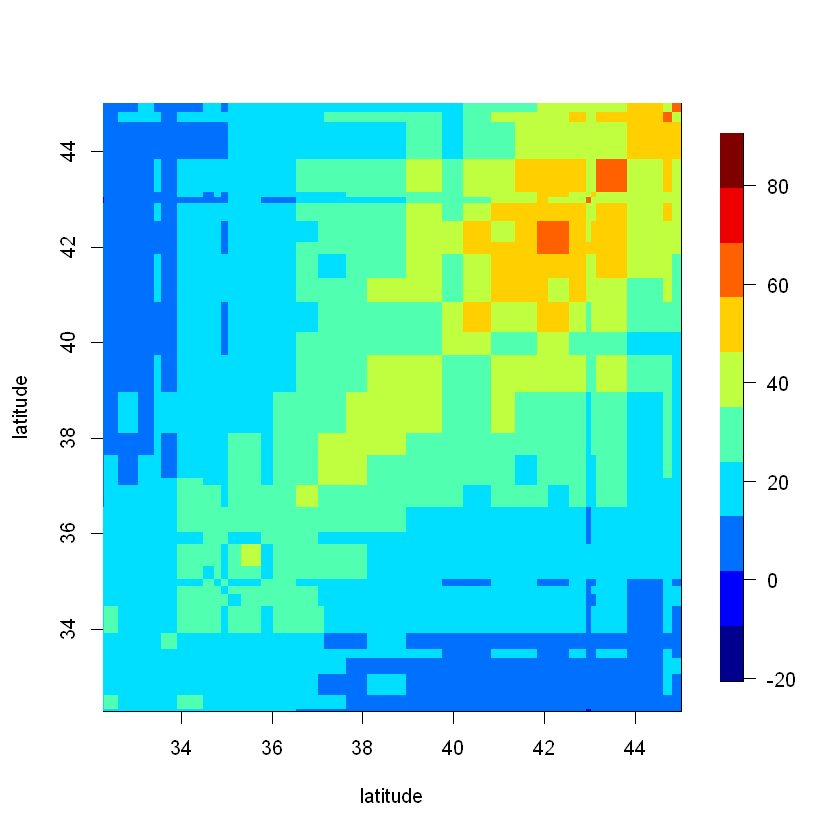

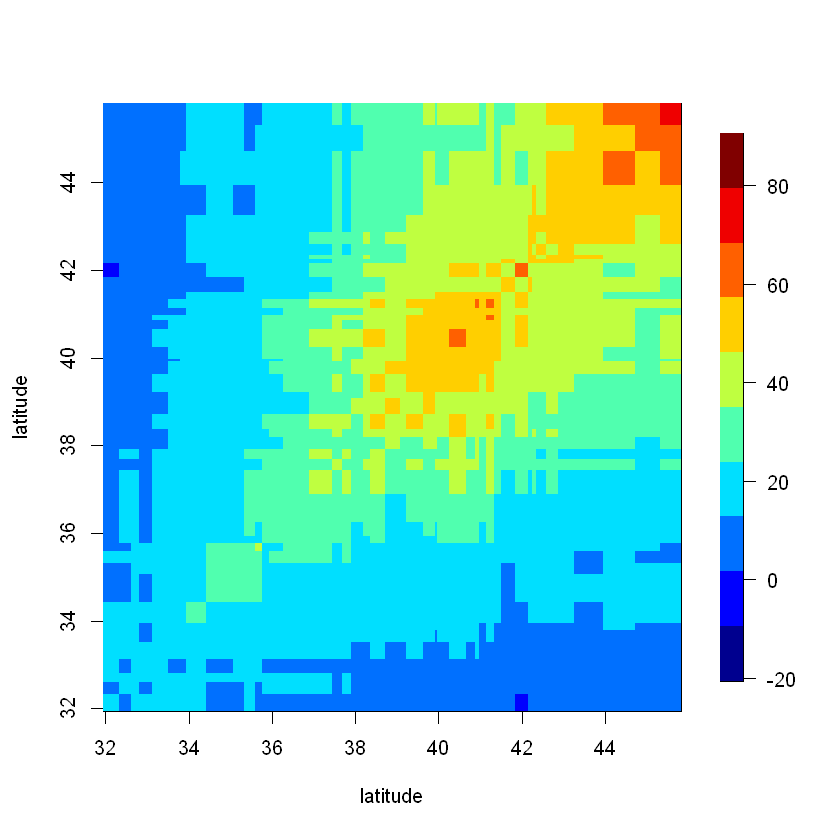

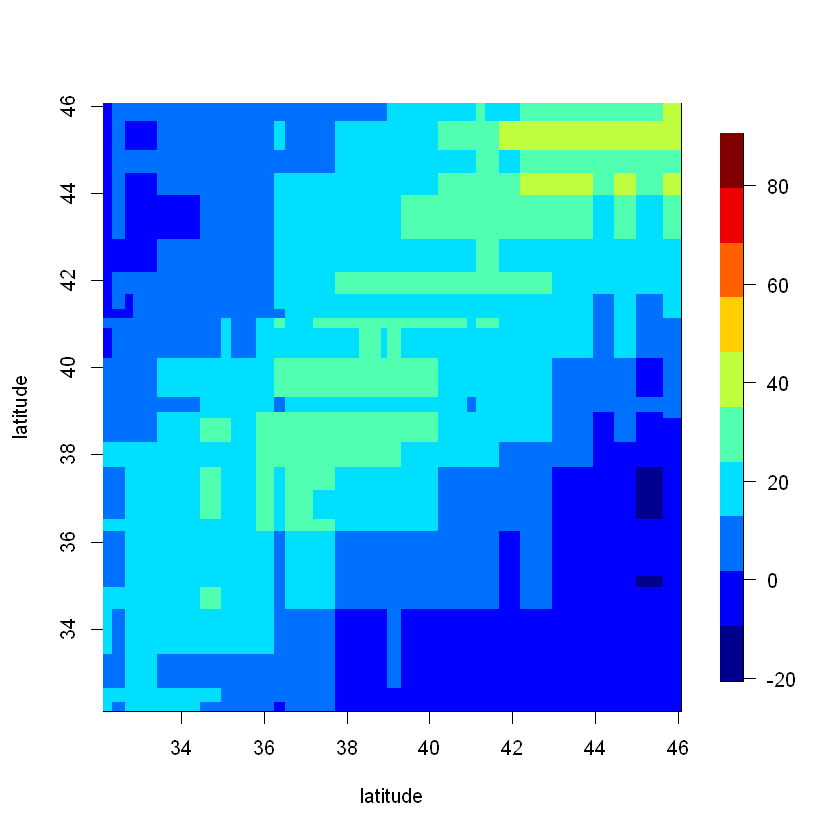

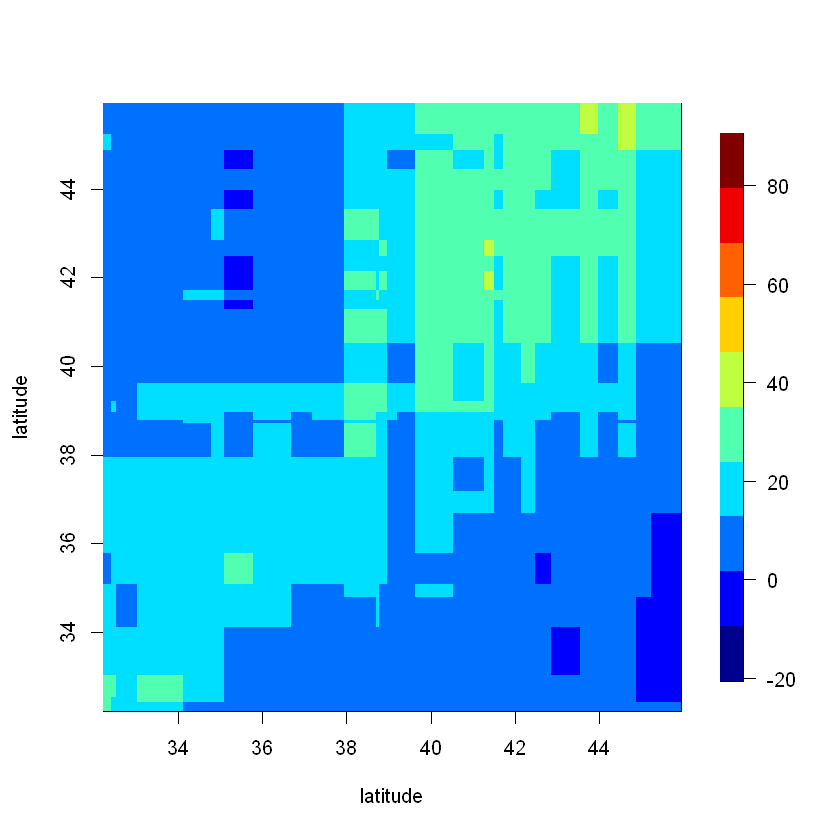

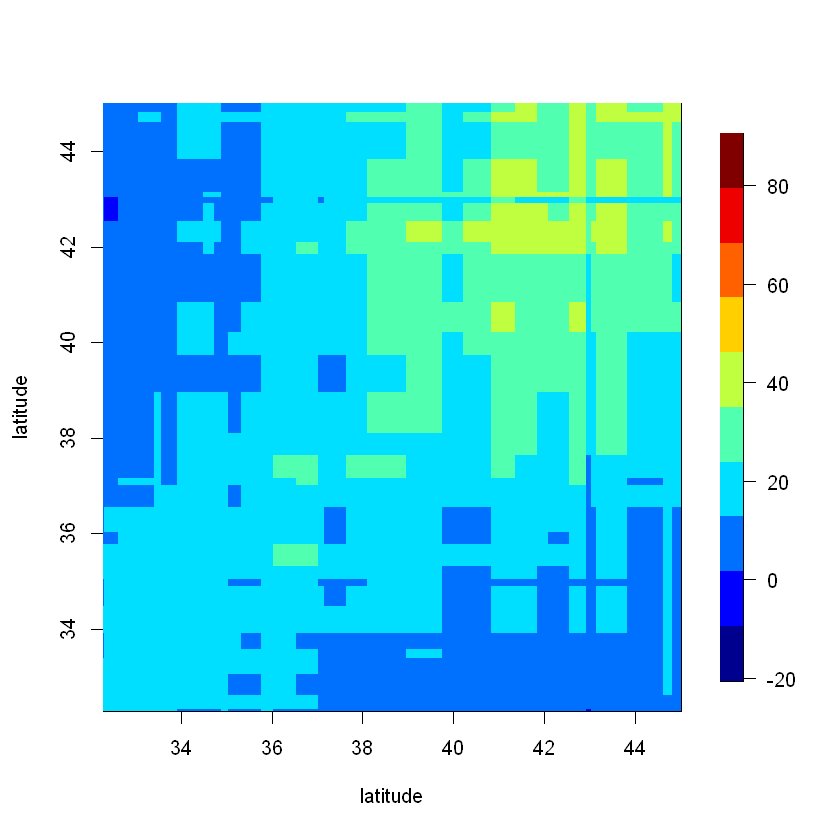

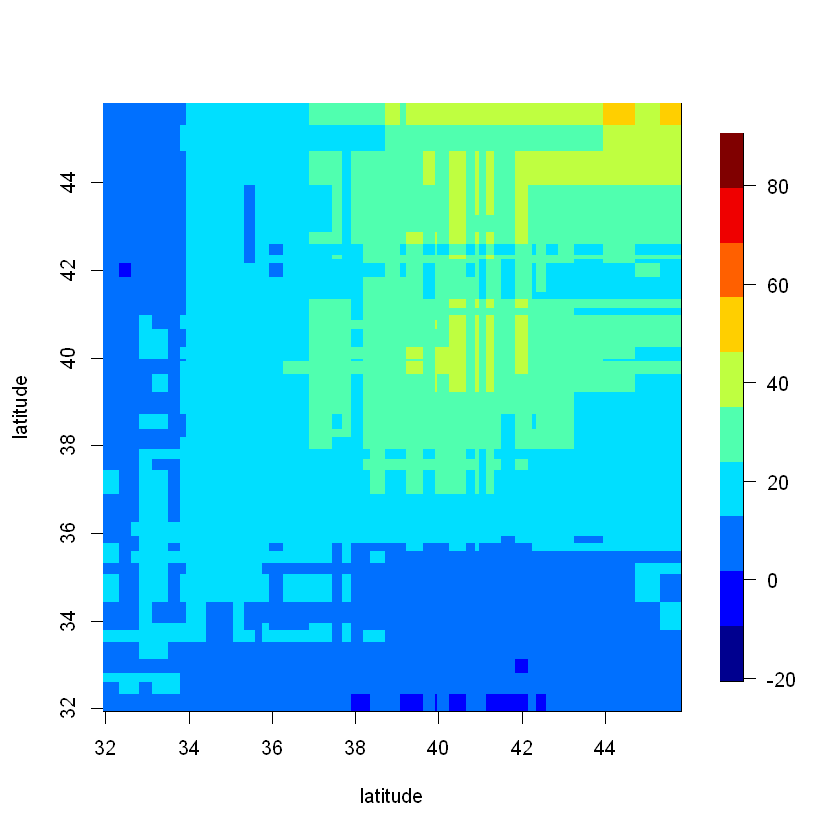

In [21]:
plot_cov_strips(Lag0_cov, spat_df)
# plot the lag-0 matrices
plot_cov_strips(Lag1_cov, spat_df)

In [22]:
data("STObj3", package = "STRbook")
STObj4 <- STObj3[, "1993-07-01::1993-07-31"]

In [23]:
vv <- variogram(object = z~1 + lat, # fixed effect component
data = STObj4,
# July data
width = 80,
# spatial bin (80 km)
cutoff = 1000,
# consider pts < 1000 km apart
tlags = 0.01:6.01)

Warning message in `[.xts`(x@time, j):
"converting 'i' to integer because it appears to contain fractions"
Warning message in `[.xts`(x@time, j):
"converting 'i' to integer because it appears to contain fractions"
Warning message in `[.xts`(x@time, j):
"converting 'i' to integer because it appears to contain fractions"
Warning message in `[.xts`(x@time, j):
"converting 'i' to integer because it appears to contain fractions"
Warning message in `[.xts`(x@time, j):
"converting 'i' to integer because it appears to contain fractions"
Warning message in `[.xts`(x@time, j):
"converting 'i' to integer because it appears to contain fractions"
Warning message in `[.xts`(x@time, j):
"converting 'i' to integer because it appears to contain fractions"
Warning message in `[.xts`(x@time, j):
"converting 'i' to integer because it appears to contain fractions"
Warning message in `[.xts`(x@time, j):
"converting 'i' to integer because it appears to contain fractions"
Warning message in `[.xts`(x@time, j)

In [24]:
data("SSTlandmask", package = "STRbook")
data("SSTlonlat", package = "STRbook")
data("SSTdata", package = "STRbook")

In [25]:
delete_rows <- which(SSTlandmask == 1)
SSTdata <- SSTdata[-delete_rows, 1:396]

In [26]:
Z <- t(SSTdata)
dim(Z)

[1]  396 2261

In [27]:
## First find the matrix we need to subtract:
spat_mean <- apply(SSTdata, 1, mean)
nT <- ncol(SSTdata)
## Then subtract and standardize:
Zspat_detrend <- Z - outer(rep(1, nT), spat_mean)
Zt <- 1/sqrt(nT - 1)*Zspat_detrend

In [28]:
E <- svd(Zt)

In [29]:
V <- E$v
colnames(E$v) <- paste0("EOF", 1:ncol(SSTdata)) # label columns
EOFs <- cbind(SSTlonlat[-delete_rows, ], E$v)
head(EOFs[, 1:6])

,lon,lat,EOF1,EOF2,EOF3,EOF4
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
16,154,-29,-0.004915064,-0.012129566,-0.02882162,8.540892e-05
17,156,-29,-0.001412275,-0.002276177,-0.02552841,6.726077e-03
18,158,-29,0.000245909,0.002298082,-0.01933020,8.591251e-03
19,160,-29,0.001454972,0.002303585,-0.01905901,1.025538e-02
20,162,-29,0.002265778,0.001643138,-0.02251571,1.125295e-02
21,164,-29,0.003598762,0.003910823,-0.02311128,1.002285e-02


In [30]:
TS <- data.frame(E$u) %>%
# convert U to data frame
mutate(t = 1:nrow(E$u)) %>%
# add a time field
gather(EOF, PC, -t)

In [31]:
TS$nPC <- TS$PC * sqrt(nT-1)

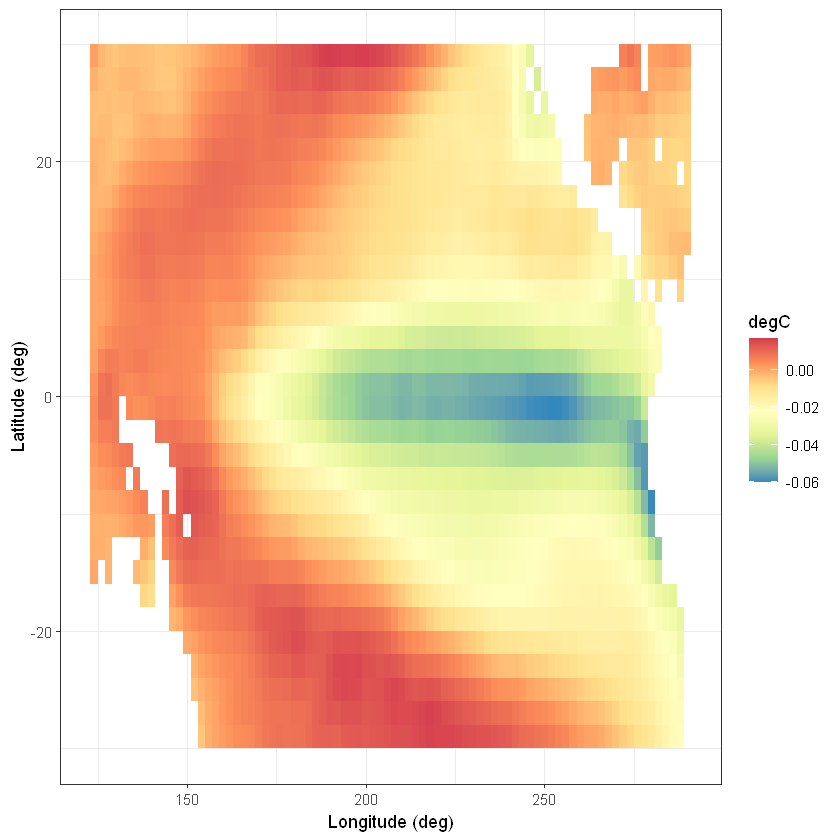

In [32]:
ggplot(EOFs) + geom_tile(aes(x = lon, y = lat, fill = EOF1)) +
fill_scale(name = "degC") + theme_bw() +
xlab("Longitude (deg)") + ylab("Latitude (deg)")

In [33]:
nEOF <- 10
EOFset1 <- E$u[1:(nT-7), 1:nEOF] * sqrt(nT - 1)
EOFset2 <- E$u[8:nT, 1:nEOF] * sqrt(nT - 1)

In [34]:
cc <- cancor(EOFset1, EOFset2)
# compute CCA
options(digits = 3)
# print to three d.p.
print(cc$cor[1:5])
# print
## [1] 0.843 0.758 0.649 0.584 0.463
print(cc$cor[6:10])

[1] 0.843 0.758 0.649 0.584 0.463
[1] 0.4137 0.3067 0.2058 0.0700 0.0273


In [35]:
CCA_df <- data.frame(t = 1:(nT - 7),
CCAvar1 = (EOFset1 %*% cc$xcoef[,1])[,1],
CCAvar2 = (EOFset2 %*% cc$ycoef[,1])[,1])

In [36]:
t_breaks <- seq(1, nT, by = 60)
# breaks for x-labels
year_breaks <- seq(1970,2002,by=5)
# labels for x-axis
g <- ggplot(CCA_df) +
geom_line(aes(t, CCAvar1), col = "dark blue") +
geom_line(aes(t, CCAvar2), col = "dark red") +
scale_x_continuous(breaks = t_breaks, labels = year_breaks) +
ylab("CCA variables") + xlab("Year") + theme_bw()

In [37]:
EOFs_CCA <- EOFs[,1:4] # first two columns are lon-lat
EOFs_CCA[,3] <- c(as.matrix(EOFs[,3:12]) %*% cc$xcoef[,1])
EOFs_CCA[,4] <- c(as.matrix(EOFs[,3:12]) %*% cc$ycoef[,1])